This tutorial is adapted from [Dair-AI Pytorch Geometric Tutorial](https://github.com/dair-ai/GNNs-Recipe) by Elvis Saravia.

## Introduction to GNNs with PyTorch Geometric

In this short notebook, the goal is to provide a introductory guide to get started with Graph Neural Networks using the popular library called [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html). PyTorch Geometric is a PyTorch based libary hence we will be using PyTorch in this tutorial. 

The code used in this tutorial has been adapted from their official [examples](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html).

In [1]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

None


In [30]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.0.0


Install the follow packages but make sure to 

---

install the right version below. Find more instructions [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) if you get lost. 

In [31]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [32]:
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [33]:
!pip install torch-geometric

## Getting Started

Import PyTorch

In [36]:
import torch

# print torch version
print(torch.__version__)

2.0.0


The great thing about PyTorch Geometric is that it contain useful functionalities to import and load graph related data. 

In [37]:
from torch_geometric.data import Data

Now let's create an unweighted and undirected graph with three nodes and four total edges.

In [38]:
# define edge list
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)

# define node features
x = torch.tensor([[-1], [0], [1]])

print(x)
# create graph data object
data = Data(x=x, edge_index=edge_index)
print(data)

tensor([[-1],
        [ 0],
        [ 1]])
Data(x=[3, 1], edge_index=[2, 4])


Our data object `Data` has many useful utility functions to check the properties of the graph. 

In [39]:
# check number of edges of the graph
print(data.num_edges)

4


In [40]:
# check number of nodes of the graph
print(data.num_nodes)

3


In [41]:
# check number of features of the graph
print(data.num_features)

1


In [42]:
# check if graph is directed
print(data.is_directed())

False


## Loading Data

Find more fun functions related to graph data [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). 

One of the cool things about the PyTorch Geometric library is that it contains out-of-the-box benchmark datasets that are ready to use and explore. A popular dataset is the Cora dataset that is used for supervised graph node classification.

"The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words." - [Papers with Code](https://paperswithcode.com/dataset/cora).

Let's load the Cora dataset:

In [43]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='tmp/Cora', name='Cora')

Let's check some of the properties of the Cora dataset.

In [44]:
# number of graphs
print("Number of graphs: ", len(dataset))

# number of features
print("Number of features: ", dataset.num_features)

# number of classes
print("Number of classes: ", dataset.num_classes)

print(dataset[0].edge_index)

Number of graphs:  1
Number of features:  1433
Number of classes:  7
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


We can see that this particular graph dataset only contains one graph. Graph data can be very complex and can include multiple graphs depending on the type of data and application. Let's check more feature of the Cora dataset:

In [45]:
# select the first graph
data = dataset[0]

# number of nodes
print("Number of nodes: ", data.num_nodes)

# number of edges
print("Number of edges: ", data.num_edges)

# check if directed
print("Is directed: ", data.is_directed())

Number of nodes:  2708
Number of edges:  10556
Is directed:  False


You can sample nodes from the graph this way:

In [46]:
# sample nodes from the graph
print("Shape of sample nodes: ", data.x[:5].shape)

Shape of sample nodes:  torch.Size([5, 1433])


We extracted 5 nodes from the graph and checked its shape. You will see that each node has `1433` features.

Another great advantage of using PyTorch Geometric to load the Cora data is that it comes pre-processed and ready to use. It also has the splits for training, validation and test which we can directly use for training a GNN.

Let's check some stats for the partitions of the data:

In [47]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

# of nodes to train on:  140
# of nodes to test on:  1000
# of nodes to validate on:  500


That information is important as it will indicate to our model which nodes to train against and which to test against, and so on.

When training neural networks we train them using batches of data. PyTorch Geometric provides efficient processes to load batches of data.

PyTorch Geometric contains a data loader which is a very popular feature in PyTorch to efficiently load data when training neural networks. 

So let's try to load the data using the built in `DataLoader`:

In [48]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
print(device)

cpu


In [50]:
dataset = Planetoid(root='tmp/Cora', name='Cora')
data = dataset[0].to(device)

Print some quick statistics about the data:

In [51]:
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


## Model and Training

Finally, let's define a standard GCN to train on the Cora dataset. The aim is to train a model that gets better at predicting the class of the node.

We are using the built-in `GCNConv` model but we could easily implement your own.

The model below uses two `GCNConv` layers. The first layer is followed by a non-linearity `ReLU` and `Dropout`. The result is fed to the second layer on top of which we apply `Softmax` to get distribution over the number of classes.

In [52]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GCNConv layers """
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Initial model and optimizer

In [53]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Define axcuracy function for evaluating performance:

In [54]:
# useful function for computing accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

And finally we train the model on the training nodes for 200 epochs:

In [55]:
# train the model
model.train()
losses = []
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))


Epoch: 10, Loss: 0.9568, Training Acc: 0.8714
Epoch: 20, Loss: 0.2883, Training Acc: 0.9786
Epoch: 30, Loss: 0.0989, Training Acc: 0.9857
Epoch: 40, Loss: 0.0835, Training Acc: 0.9929
Epoch: 50, Loss: 0.0533, Training Acc: 1.0000
Epoch: 60, Loss: 0.0482, Training Acc: 0.9929
Epoch: 70, Loss: 0.0524, Training Acc: 0.9857
Epoch: 80, Loss: 0.0268, Training Acc: 1.0000
Epoch: 90, Loss: 0.0412, Training Acc: 1.0000
Epoch: 100, Loss: 0.0402, Training Acc: 1.0000
Epoch: 110, Loss: 0.0298, Training Acc: 1.0000
Epoch: 120, Loss: 0.0350, Training Acc: 1.0000
Epoch: 130, Loss: 0.0563, Training Acc: 0.9857
Epoch: 140, Loss: 0.0309, Training Acc: 0.9929
Epoch: 150, Loss: 0.0314, Training Acc: 1.0000
Epoch: 160, Loss: 0.0246, Training Acc: 1.0000
Epoch: 170, Loss: 0.0416, Training Acc: 0.9929
Epoch: 180, Loss: 0.0380, Training Acc: 1.0000
Epoch: 190, Loss: 0.0335, Training Acc: 1.0000
Epoch: 200, Loss: 0.0184, Training Acc: 1.0000


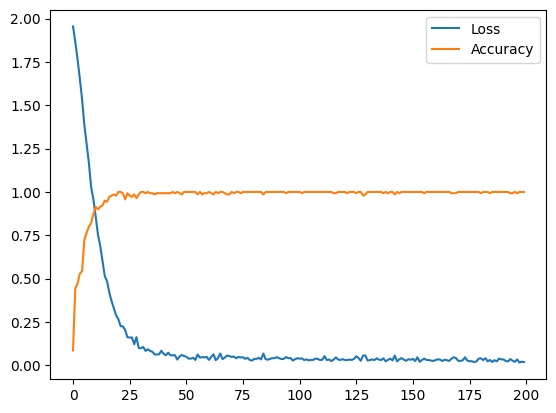

In [56]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

It looks like the model achieves a very high accuracy and small loss on the training dataset. To see how well it generalizes, let's test on the testing nodes:

In [27]:
# evaluate the model on test set
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8110


Very cool! It seems we got a very nice accuracy for the test as well. Our model is doing okay. There are many ways you can go about trying to improve this model, but we will keep that for another time. Hopefully, with this tutorial you got a glimpse of graph data and how to use PyTorch Geometric to train GNNs on a very popular dataset. 